In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)
random.seed(123)

# Create parameters

In [3]:
alpha = 1 # proximal term coefficient
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

num_agents = num_commodities = 100

filename = "mcf_N%d_%.2f_n%d"%(num_points, eps_sublevel, num_agents)

In [4]:
num_vertices = 15
num_edges = 100

params, A_ineq, b_ineq = mra.mcf_data(num_vertices, num_edges, num_commodities)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_multi_commodity_flow(params, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-127.94975171699481


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.9999999999932164

In [8]:
true_lamb.shape, true_x.shape

((100, 1), (10000, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions(lamb_k, i, params[i], 
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions_noisy_prices(lamb_k, i, params[i], percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.mcf_obj_value(x_k, params)

# Localization

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [11]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=150, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=150, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/tepars/Documents/postdoc/mra_precovery/mra

epoch=0, f_subopt_xk=6.7420E-01,  f_subopt_mra=5.7383E-01,  viol_xk=2.7134E+02, viol_mra=2.5641E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=5.5173E-02,  f_subopt_mra=4.4376E-02,  viol_xk=4.7551E+01, viol_mra=1.6995E+01, lamb_rel_diff=4.5947E-02
epoch=100, f_subopt_xk=7.2283E-03,  f_subopt_mra=7.2771E-03,  viol_xk=4.6605E+01, viol_mra=2.5523E+01, lamb_rel_diff=3.5548E-02
epoch=149, f_subopt_xk=3.1005E-03,  f_subopt_mra=2.9796E-03,  viol_xk=5.1227E+01, viol_mra=3.8879E+01, lamb_rel_diff=2.9438E-02
epoch=0, f_subopt_xk=6.7420E-01,  f_subopt_mra=6.4607E-01,  viol_xk=2.7134E+02, viol_mra=2.6758E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=5.5173E-02,  f_subopt_mra=3.0253E-02,  viol_xk=4.7551E+01, viol_mra=1.7756E+01, lamb_rel_diff=4.5947E-02
epoch=100, f_subopt_xk=7.2283E-03,  f_subopt_mra=2.2715E-03,  viol_xk=4.6605E+01, viol_mra=4.4825E+00, lamb_rel_diff=3.5548E-02
epoch=149, f_subopt_xk=3.1005E-03,  f_subopt_mra=1.3285E-03,  viol_xk=5.1227E+01, viol_mra=6.7012E-02, lamb_rel_diff=2.9438E

In [12]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

T=150
0.0031004794643699615 sub_eps 0.0029795837154402583 noisy_y 0.0013284713444465463 proj 0.623414616730414


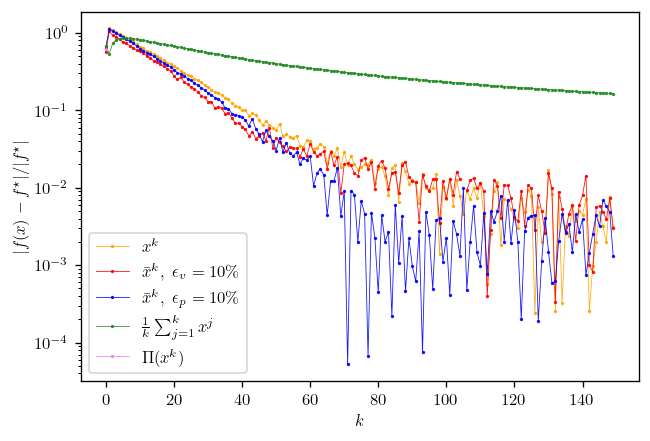

In [28]:
mra.plot_func_subopt_all(all_res, all_results_eps, all_results_noisy_y, true_f, eps_sublevel, percent, 
                        filename=filename)

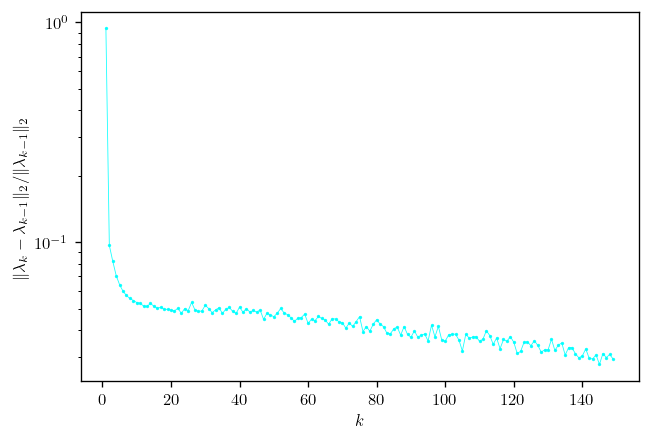

In [29]:
mra.plot_lamb_k_diff(all_res, filename)

In [30]:
print(np.array(all_res["viol_primal_xk"])[-1],
      "sub_eps", np.array(all_results_eps["viol_primal_mra_xk"])[-1],
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"])[-1])

32.133971592337666 sub_eps 24.01720940486847 noisy_y 5.217279172631262e-06


In [31]:
print("sub_eps", np.array(all_results_eps["viol_primal_mra_xk"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"]).size)

sub_eps 150 noisy_y 150


T=150
1.6409371999232134 sub_eps 1.2264507123729396 noisy_y 2.6642294906355937e-07


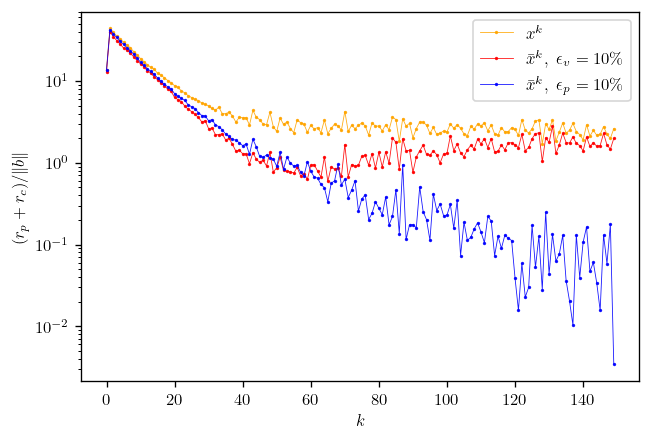

In [32]:
mra.plot_prim_complem_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                               filename=filename)

T=150
1.6409371999232134 sub_eps 1.2264507123729396 noisy_y 2.6642294906355937e-07


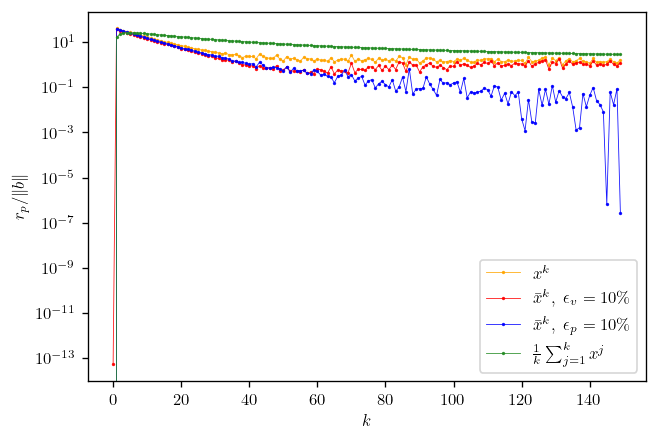

In [33]:
mra.plot_prim_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                       filename=filename)

T=150


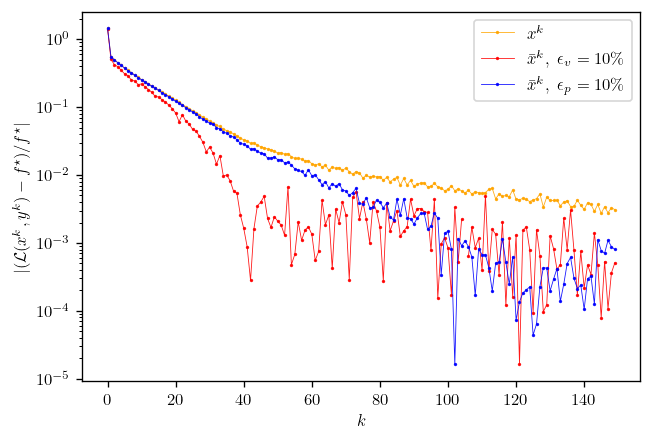

In [34]:
mra.plot_lagr_subopt_all(all_res, all_results_eps, all_results_noisy_y, eps_sublevel, percent, true_f=true_f,
                        filename=filename)

In [27]:
T = 150
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[1:]) + 1
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[1:]) + 1
idx_noisy_y = np.argmin(np.array(all_results_noisy_y["viol_primal_mra_xk"][1:])) + 1
idx_eps = np.argmin(np.array(all_results_eps["viol_primal_mra_xk"])[1:]) + 1

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

idx_xk=128, idx_eps=65, idx_noisy_y=149, idx_paverage=149
xk 0.001978705754374496 sub_eps 0.01736879894193798 noisy_y 0.0013284713444465463 proj 0.623414616730414 paverage 0.16453210917785158
xk 18.736362785397496 sub_eps 7.595019218666855 noisy_y 5.217279172631262e-06 paverage 55.30600157814882


In [24]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
# res["eps"].keys()

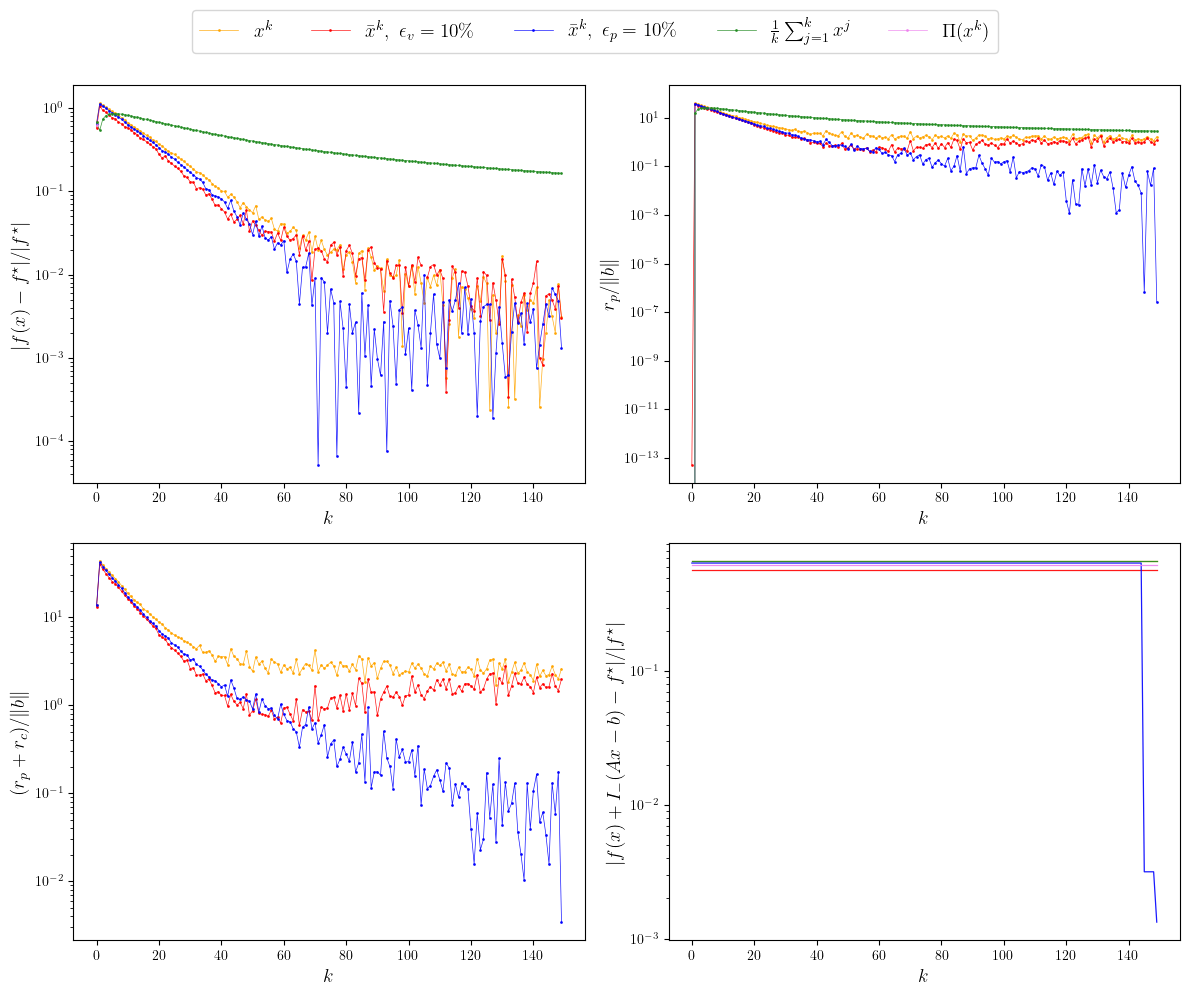

In [25]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T=150)